# Introduction

In an attempt to better understand the information in our tweets, we conducted visualizations on the following:
1. <b>Hashtag Correlations</b> - Hashtags indicate topics and themes which classify messages and improve searchability. Hence, we explored the most common hashtags present in the dataset and if the most popular hashtags were correlated to each other.
2. <b>Most Common Words</b> - Since the tweets data set focuses on climate change, we were intrigued to know which words are most commonly used by the users. This was visualized using a bar plot of the 30 most popular words and a “word cloud” of all the words available in our data set. However, the size of the word in “word cloud” represented the frequency. For instance, the word "amp" (ain't my problem) has the biggest size indicating the highest frequency.
3. <b>Bi-Gram</b> - Bi-gram is a sequence of two adjacent elements from a string of tokens, which are typical letters, syllables, or words. And, as words get their meaning from the words surrounding them, therefore we identified co-occurring words. The top 25 co-occurring words were visualized using a bar plot and network.

*References*
* https://ourcodingclub.github.io/tutorials/topic-modelling-python/
* https://networkx.org/documentation/latest/auto_examples/drawing/plot_simple_path.html#sphx-glr-auto-examples-drawing-plot-simple-path-py
* https://www.datacamp.com/community/tutorials/wordcloud-python

#### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import itertools
import collections
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import sys
import wordcloud as WordCloud
import plotly.graph_objs as go
from sklearn.feature_extraction.text import CountVectorizer
import networkx as nx
from nltk import bigrams

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sanyaanand/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Read cleaned data

In [2]:
data = pd.read_csv('./cleaned_data.csv')
data.head()

date            id  \
0  2021-05-06 22:04:41  1.390427e+18   
1  2021-05-06 22:04:19  1.390427e+18   
2  2021-05-06 22:04:18  1.390427e+18   
3  2021-05-06 22:04:16  1.390427e+18   
4  2021-05-06 22:04:15  1.390427e+18   

                                         tweets_text  \
0  For my part the animal welfare issues alone we...   
1  Joe Biden Mentions Racial Justice and Climate ...   
2  @KaciekkArt Does this make sense? https://t.co...   
3  @mitsukos619 Climate change is nothing more th...   
4  Fevers are plaguing the oceans — and climate c...   

                                           clean_txt  \
0  for my part the animal welfare issues alone we...   
1  joe biden mentions racial justice and climate ...   
2                    kaciekkart does this make sense   
3   climate change is nothing more than a backdoo...   
4  fevers are plaguing the oceans and climate cha...   

                                    clean_words_text  tweet_length  
0  part animal welfare issue alone sufficient man...           267  
1  joe biden mention racial justice national day ...            98  
2                              kaciekkart make sense            31  
3  nothing backdoor communist democrat party push...           264  
4                  fever plaguing ocean making worse            70

In [3]:
print(data['clean_words_text'].isna().sum())

2


In [4]:
# fill na values in clean_words_text column
data['clean_words_text']=data['clean_words_text'].fillna("")

### Hashtags Correlations

In [5]:
# function fo finding hashtags in each tweet
def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)
data['hashtags'] = data['tweets_text'].apply(find_hashtags)

In [6]:
# take rows with only hashtags
hashtags_list_df = data.loc[data.hashtags.apply(lambda hashtags_list: hashtags_list !=[]),['hashtags']]

In [7]:
# create dataframe where each hashtags is assigned a separate row
flattened_hashtags_df = pd.DataFrame([hashtag for hashtags_list in hashtags_list_df.hashtags for hashtag in hashtags_list],
    columns=['hashtag']) 

In [8]:
# count each hashtag
popular_hashtags = flattened_hashtags_df.groupby('hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True) 

In [9]:
# find popular hashtags
min_appearance = 20
popular_hashtags_set = set(popular_hashtags[
                           popular_hashtags.counts>=min_appearance
                           ]['hashtag'])

In [10]:
# create column with only popular hashtags
hashtags_list_df['popular_hashtags'] = hashtags_list_df.hashtags.apply(
            lambda hashtag_list: [hashtag for hashtag in hashtag_list
                                  if hashtag in popular_hashtags_set])

In [11]:
# drop rows without popular hashtag
popular_hashtags_list_df = hashtags_list_df.loc[
            hashtags_list_df.popular_hashtags.apply(lambda hashtag_list: hashtag_list !=[])]

In [12]:
# make new dataframe
hashtag_vector_df = popular_hashtags_list_df.loc[:, ['popular_hashtags']]

for hashtag in popular_hashtags_set:
    # make columns to encode presence of hashtags
    hashtag_vector_df['{}'.format(hashtag)] = hashtag_vector_df.popular_hashtags.apply(
        lambda hashtag_list: int(hashtag in hashtag_list))

In [13]:
# Drop popular_hashtags columns
hashtag_matrix = hashtag_vector_df.drop('popular_hashtags', axis=1)

#### Observation
"BirdTellUs" and "GrowingClimateSolution" have the highest positive correlation which suggests that these two hashtags occurred frequently with each other.

In [14]:
# calculate the correlation matrix
correlations = hashtag_matrix.corr()

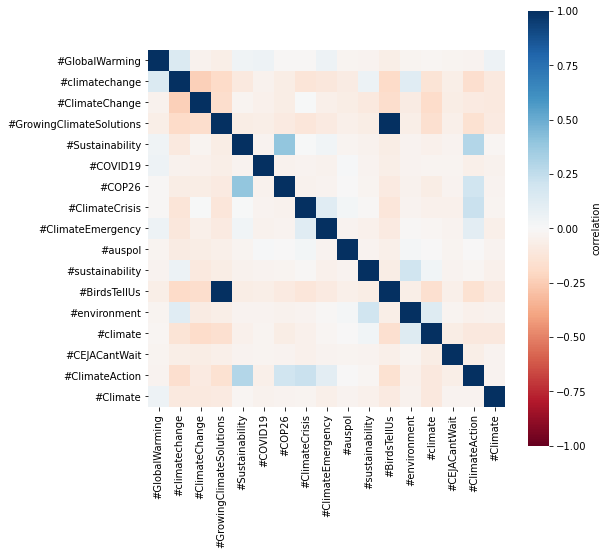

In [15]:
# plot the correlation matrix
plt.figure(figsize=(8,8))
sns.heatmap(correlations,
    cmap='RdBu',
    vmin=-1,
    vmax=1,
    square = True,
    cbar_kws={'label':'correlation'})
plt.show()

### Most Common Words

#### Bar Plot
Top 25 common words are plotted according to their occurrences and the most common words are "amp","people","u" and "world.

In [16]:
# Flatten list of words in clean tweets
data['tokens'] = data['clean_words_text'].apply(word_tokenize) 
all_words_nsw_nc = list(itertools.chain(*data['tokens']))

In [17]:
# Create counter of words in clean tweets
counts_nsw_nc = collections.Counter(all_words_nsw_nc)
clean_tweets_ncw = pd.DataFrame(counts_nsw_nc.most_common(30),
                             columns=['words', 'count'])

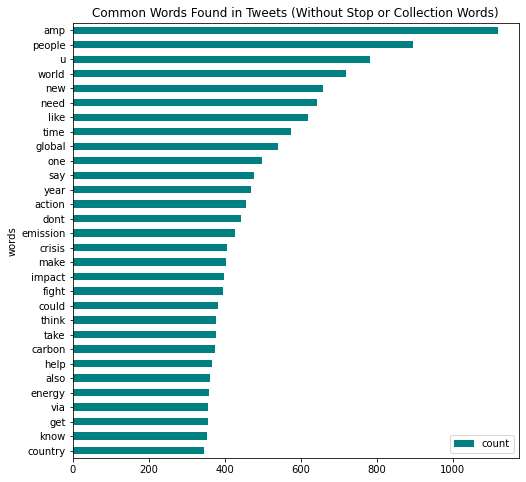

In [18]:
# Plot horizontal bar graph
fig, ax = plt.subplots(figsize=(8, 8))

clean_tweets_ncw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="teal")

ax.set_title("Common Words Found in Tweets (Without Stop or Collection Words)")

plt.show()

#### Word Cloud
The size of the word represents the frequency of the words in the whole data set. We can see that words such as "china", "biden" and "real" are extremely small in size indicating the least occurrence of them. 

In [19]:
#create dictionary mapping of word count
clean_tweets_ncw = pd.DataFrame(counts_nsw_nc.most_common(len(counts_nsw_nc)),
                             columns=['words', 'count'])

top_dictionary = dict(zip(clean_tweets_ncw['words'], clean_tweets_ncw['count']))

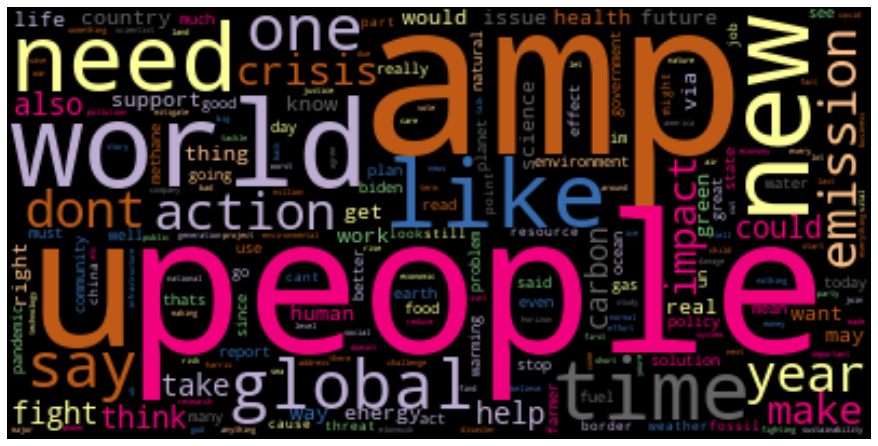

In [20]:
#Create Word Cloud 
wordcloud = WordCloud.WordCloud(colormap = 'Accent', background_color = 'black').generate_from_frequencies(top_dictionary)

#plot with matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

### Bi-gram

#### Bar Plot
Among the top 25 co-occurring words, the most common words observed were "global warming", "time horizon", "fossil fuel" and "take action".

In [21]:
# Function for Bi-gram
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [22]:
# Plot of top 25 bigrams for the cleaned text
common_words = get_top_n_bigram(data['clean_words_text'], 25)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])
fig = go.Figure([go.Bar(x=df3['bigram'], y=df3['count'])])
fig.update_layout(title=go.layout.Title(text="Top 25 bigrams for the cleaned text"))
fig.show()

#### Network Analysis Graph for Bi-grams
This plot displays the networks of top 25 co-occurring words in tweets on climate change. Words such as "time, horizon", "carbon, emission", "resources, available" occur together. 

In [23]:
# Create list of lists containing bigrams in tweets
terms_bigram = [list(bigrams(tweet)) for tweet in data['tokens']]

In [24]:
# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

In [25]:
# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

bigram_df = pd.DataFrame(bigram_counts.most_common(25),
                             columns=['bigram', 'count'])

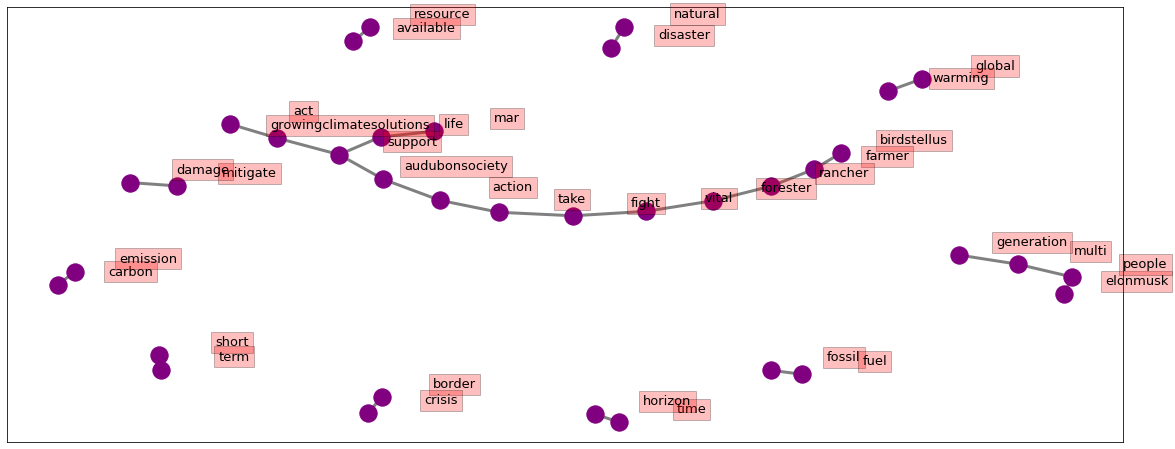

In [26]:
# Network Analysis
# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

fig, ax = plt.subplots(figsize=(20, 8))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()